In [1]:
import pandas as pd
import PIL
from PIL import Image
import torch
from torch import nn, optim
import numpy as np

/home/pedro/anaconda3/envs/dc_claas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
instruments = pd.read_csv('music_data_img.csv').iloc[:,1:]

In [3]:
instruments.columns

Index(['Instrument_Type', 'Image_File'], dtype='object')

In [4]:
instruments['Instrument_Type'].value_counts()

Studio / Live Music Equipment    1142
String Instrument / Amplifier    1089
Keyboard / Piano                  418
Percussion / drums                393
Other Instrument                  104
Woodwind / brass                   45
Sheet Music                        30
Vinyl                              23
Name: Instrument_Type, dtype: int64

In [5]:
non_existant = []
images = {'Instrument':[],'Image':[]}
for i, v in zip(instruments['Image_File'],instruments['Instrument_Type']):
    print(i)
    try:
        images['Image'].append(Image.open(i))
        images['Instrument'].append(v)
    except:
        pass

music_instruments_images/1634109508851_Yamaha SY77 Music Synthesizer for sale.jpg
music_instruments_images/1634109509147_SRX718 BASS BIN PAIR for sale.jpg
music_instruments_images/1634109509344_Piano Malcom Mendis Piano for sale.jpg
music_instruments_images/1634109509573_Yamaha Semi Acoustic Guitars for sale.jpg
music_instruments_images/1634109510073_Yamaha Guitar for sale.jpg
music_instruments_images/1634109510808_Violin for sale.jpg
music_instruments_images/1634109511077_Expnsoin Card Xp 30506080 for sale.jpg
music_instruments_images/1634109511477_à·à¶ºà·à¶©à· à¶©à·âà¶»à¶¸à· for sale.jpg
music_instruments_images/1634109511904_semi acoustic box guitar for sale.jpg
music_instruments_images/1634109512354_32 keys Melodica full set for sale.jpg
music_instruments_images/1634109513457_Guitar wall stand for sale.jpg
music_instruments_images/1634109513875_Fender 41 box guitar for sale.jpg
music_instruments_images/1634109514397_Dilipsons Piano Center for sale.jpg
music_instruments_image

In [6]:
images['Image'][0].size

(160, 120)

In [7]:
tamanhos_imagens = set()
for i in images['Image']:
    tamanhos_imagens.add(i.size)

In [8]:
tamanhos_imagens

{(142, 107), (160, 120)}

## Now it is important to resize the images, or else we won't be able to fit them into a tensor

### Example

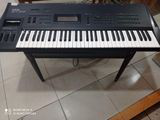

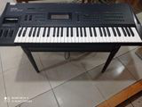

In [9]:
antes = []
depois = []
for i in images['Image']:
    if i.size == (160,120):
        depois.append(i.resize(size=(142, 107)))
        antes.append(i) 
display(antes[0],depois[0])

In [10]:
images

{'Instrument': ['Keyboard / Piano',
  'Studio / Live Music Equipment',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'Keyboard / Piano',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'Studio / Live Music Equipment',
  'Percussion / drums',
  'Percussion / drums',
  'Studio / Live Music Equipment',
  'Keyboard / Piano',
  'Studio / Live Music Equipment',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'Other Instrument',
  'String Instrument / Amplifier',
  'Studio / Live Music Equipment',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'Keyboard / Piano',
  'String Instrument / Amplifier',
  'String Instrument / Amplifier',
  'Studio / Live M

# Fitting it back to a DataFrame, but as a numpy array

In [11]:
for index, image in enumerate(images['Image']):
    img = image.resize(size=(50, 50))
    images['Image'][index] = np.asarray(img)

In [12]:
images['Image'] = np.array(images['Image'])

In [13]:
images['Image'].shape

(3176, 50, 50, 3)

# Now we're already able to turn images to tensors and start using torch's neural networks on them!

In [14]:
target_encoder = {v: i for i,v in dict(enumerate(instruments['Instrument_Type'].unique())).items()}
for i, v in enumerate(images['Instrument']):
    images['Instrument'][i] = target_encoder[v]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images['Image'], np.array(images['Instrument']), test_size=0.2)

In [16]:
from torch.utils.data import DataLoader
class Dataset(object):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_loader = DataLoader(Dataset(X_train, y_train), batch_size=30, shuffle=True)
test_loader = DataLoader(Dataset(X_test, y_test), batch_size=30, shuffle=True)

In [17]:
import torch.nn.functional as F
import math

class NeuralNetworking(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten =  nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.convLayer1 = nn.Conv2d(3, 6, 7)
        self.convLayer2 = nn.Conv2d(6, 16, 5)              
        self.linear_layers = nn.Sequential(
                      nn.Linear(9*9*16,8*8),
                      nn.ReLU(),
                      nn.Linear(8*8,8*3),
                      nn.ReLU(),
                      nn.Linear(8*3,output_size)
                      )

    def forward(self, x):
        x = self.pool(F.relu(self.convLayer1(x)))
        x = self.pool(F.relu(self.convLayer2(x)))
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x

In [23]:
model = NeuralNetworking(50*50*3,8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=1e-3)

In [24]:
epochs = 40

for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader):
        y_pred = model(X.view(X.shape[0],3,50,50))
        optimizer.zero_grad()

        loss = criterion(y_pred, y.type(torch.long))
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f'currently at epoch {epoch} iteration number {i} with loss {loss}')

currently at epoch 0 iteration number 0 with loss 5.022406578063965
currently at epoch 0 iteration number 10 with loss 1.8704975843429565
currently at epoch 0 iteration number 20 with loss 1.6090805530548096
currently at epoch 0 iteration number 30 with loss 1.5962070226669312
currently at epoch 0 iteration number 40 with loss 1.4614946842193604
currently at epoch 0 iteration number 50 with loss 1.3226453065872192
currently at epoch 0 iteration number 60 with loss 1.4381670951843262
currently at epoch 0 iteration number 70 with loss 1.571940302848816
currently at epoch 0 iteration number 80 with loss 1.6476495265960693
currently at epoch 1 iteration number 0 with loss 1.5171445608139038
currently at epoch 1 iteration number 10 with loss 1.5101009607315063
currently at epoch 1 iteration number 20 with loss 1.472067952156067
currently at epoch 1 iteration number 30 with loss 1.5730940103530884
currently at epoch 1 iteration number 40 with loss 1.377838134765625
currently at epoch 1 itera

In [36]:
got_it_right = {0:[0,0],1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0],6:[0,0],7:[0,0]}
predict_list = []
total = 0
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        y_pred = model(X.view(X.shape[0],3,50,50))
        _, predictions = torch.max(y_pred,1)
        for actual, predicted in zip(y,predictions):
            got_it_right[int(actual)][1] +=1
            predict_list.append(int(predicted))
            if actual == predicted:
                got_it_right[int(actual)][0] +=1

encoder = {value:key for key,value in target_encoder.items()}

{encoder[i]:v[0]/v[1] for i, v in got_it_right.items()}

{'Keyboard / Piano': 0.1702127659574468,
 'Studio / Live Music Equipment': 0.5255813953488372,
 'String Instrument / Amplifier': 0.5260663507109005,
 'Percussion / drums': 0.2465753424657534,
 'Other Instrument': 0.07692307692307693,
 'Woodwind / brass': 0.2222222222222222,
 'Sheet Music': 0.0,
 'Vinyl': 0.0}